In [14]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.statespace.sarimax import SARIMAX
from pmdarima import auto_arima

In [5]:
# Loading the Data 
df = pd.read_csv("C:/Users/akash/OneDrive/Desktop/NRL Project/HMS 1.csv")
df['Date'] = pd.to_datetime(df['Date'], dayfirst=True)
df = df.sort_values('Date')
df.set_index('Date', inplace=True)
series = df['Price'].astype(float)


In [6]:
# Stationarity Check (ADF Test on Original Data)
def adfuller_test(series, title=""):
    print(f"\nADF Test: {title}")
    result = adfuller(series.dropna())
    labels = ['ADF Statistic', 'p-value', '# Lags Used', '# Observations']
    for value, label in zip(result, labels):
        print(f"{label}: {value}")
    if result[1] <= 0.05:
        print("=> Stationary (Reject H0)")
    else:
        print("=> Non-stationary (Fail to reject H0)")

adfuller_test(series, "Original Series")


ADF Test: Original Series
ADF Statistic: -1.243422645922275
p-value: 0.6546431906063768
# Lags Used: 3
# Observations: 258
=> Non-stationary (Fail to reject H0)


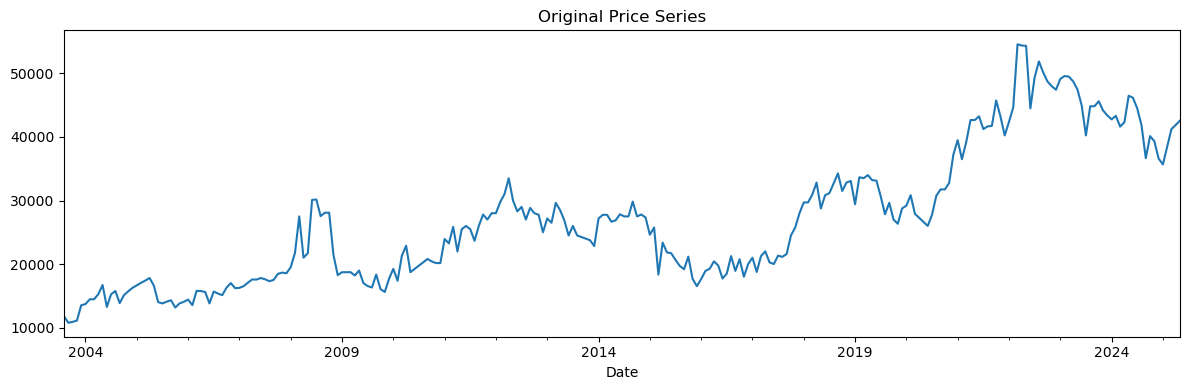

In [7]:
# Step 3: Visualize Series
series.plot(figsize=(12, 4), title='Original Price Series')
plt.tight_layout()
plt.show()

In [8]:
#First Differencing (d = 1)
df['First Difference'] = series - series.shift(1)
adfuller_test(df['First Difference'], "After First Difference")


ADF Test: After First Difference
ADF Statistic: -11.482548765080638
p-value: 4.954050253620819e-21
# Lags Used: 2
# Observations: 258
=> Stationary (Reject H0)


In [9]:
#Seasonal Differencing (D = 1, m = 48)
m = 48  # Assuming 4-year seasonal cycle
df['Seasonal First Diff'] = df['First Difference'] - df['First Difference'].shift(m)
adfuller_test(df['Seasonal First Diff'], "After First + Seasonal Differencing")


ADF Test: After First + Seasonal Differencing
ADF Statistic: -18.33044686708151
p-value: 2.256392209140734e-30
# Lags Used: 0
# Observations: 212
=> Stationary (Reject H0)


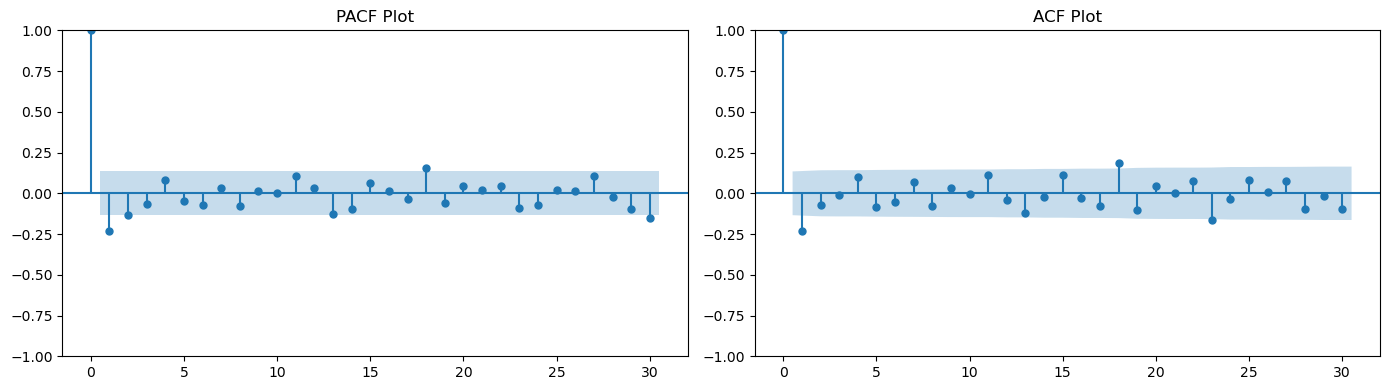

In [10]:
# Plotting ACF & PACF to Estimate p and q
fig, axes = plt.subplots(1, 2, figsize=(14, 4))
plot_pacf(df['Seasonal First Diff'].dropna(), ax=axes[0], lags=30)
axes[0].set_title("PACF Plot")
plot_acf(df['Seasonal First Diff'].dropna(), ax=axes[1], lags=30)
axes[1].set_title("ACF Plot")
plt.tight_layout()
plt.show()

In [11]:
# Fitting auto_arima to confirm SARIMA(p,d,q)(P,D,Q)[m]
stepwise_model = auto_arima(
    series,
    start_p=0, start_q=0, max_p=3, max_q=3,
    seasonal=True, m=m,
    start_P=0, start_Q=0, max_P=2, max_Q=2,
    d=1, D=1, trace=True,
    error_action='ignore', suppress_warnings=True,
    stepwise=True
)

print("\nBest Model Summary (from auto_arima):")
print(stepwise_model.summary())

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,1,0)[48]             : AIC=4042.855, Time=0.43 sec
 ARIMA(1,1,0)(1,1,0)[48]             : AIC=3988.140, Time=3.10 sec
 ARIMA(0,1,1)(0,1,1)[48]             : AIC=inf, Time=5.53 sec
 ARIMA(1,1,0)(0,1,0)[48]             : AIC=4033.110, Time=0.29 sec
 ARIMA(1,1,0)(2,1,0)[48]             : AIC=3969.920, Time=11.21 sec
 ARIMA(1,1,0)(2,1,1)[48]             : AIC=inf, Time=15.13 sec
 ARIMA(1,1,0)(1,1,1)[48]             : AIC=inf, Time=5.32 sec
 ARIMA(0,1,0)(2,1,0)[48]             : AIC=3975.376, Time=2.93 sec
 ARIMA(2,1,0)(2,1,0)[48]             : AIC=3967.112, Time=13.32 sec
 ARIMA(2,1,0)(1,1,0)[48]             : AIC=3983.301, Time=4.97 sec
 ARIMA(2,1,0)(2,1,1)[48]             : AIC=inf, Time=27.71 sec
 ARIMA(2,1,0)(1,1,1)[48]             : AIC=inf, Time=11.30 sec
 ARIMA(3,1,0)(2,1,0)[48]             : AIC=3968.038, Time=15.10 sec
 ARIMA(2,1,1)(2,1,0)[48]             : AIC=3968.597, Time=20.67 sec
 ARIMA(1,1,1)(2,1,0)[48]             

In [16]:
# Fitting SARIMA Model
# Order and seasonal_order were used from auto_arima
model = SARIMAX(series,
                order=(2, 1, 0),
                seasonal_order=(2, 1, 0, 48))
results = model.fit(disp=False)

C:\Users\akash\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\akash\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


In [17]:

# Forecasting
forecast_steps = 300
forecast = results.get_forecast(steps=forecast_steps)
forecast_index = pd.date_range(series.index[-1] + pd.offsets.MonthBegin(1),
                               periods=forecast_steps, freq='MS')

forecast_df = pd.DataFrame({
    'Date': forecast_index,
    'Forecasted Price': forecast.predicted_mean
})

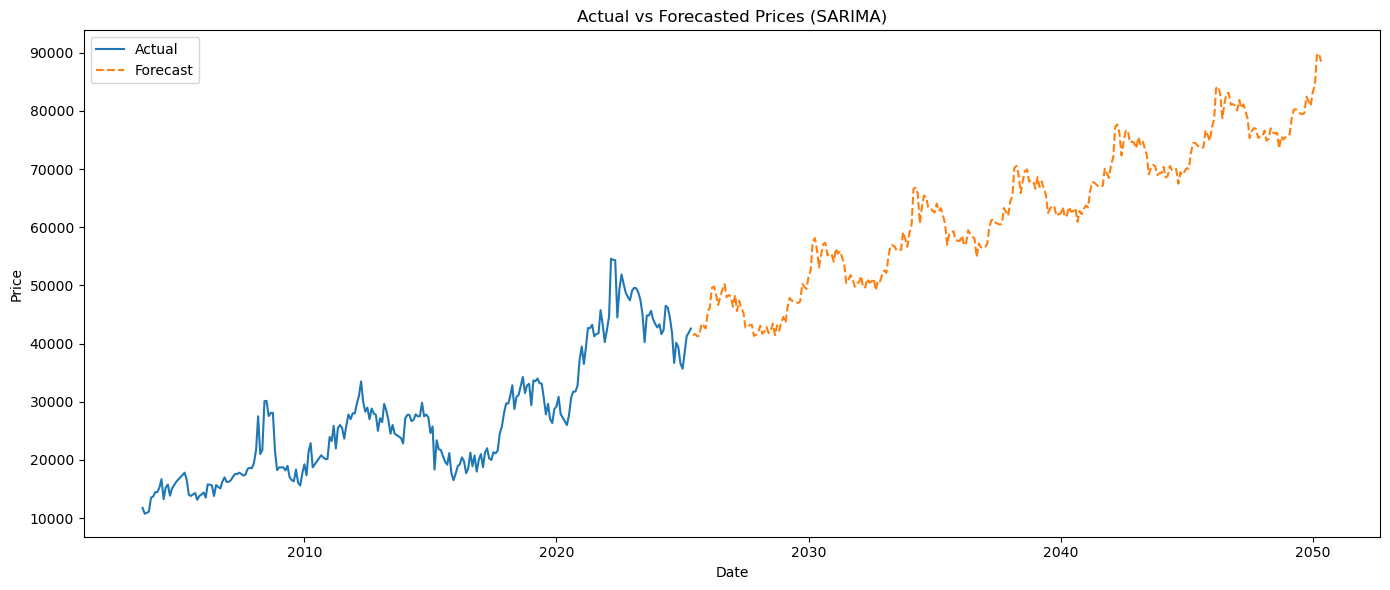

In [18]:
# Plotting Actual vs Forecast
plt.figure(figsize=(14, 6))
plt.plot(series.index, series, label='Actual')
plt.plot(forecast_df['Date'], forecast_df['Forecasted Price'], label='Forecast', linestyle='--')
plt.xlabel('Date')
plt.ylabel('Price')
plt.title('Actual vs Forecasted Prices (SARIMA)')
plt.legend()
plt.tight_layout()
plt.savefig('sarima_forecast_plot.png')
plt.show()

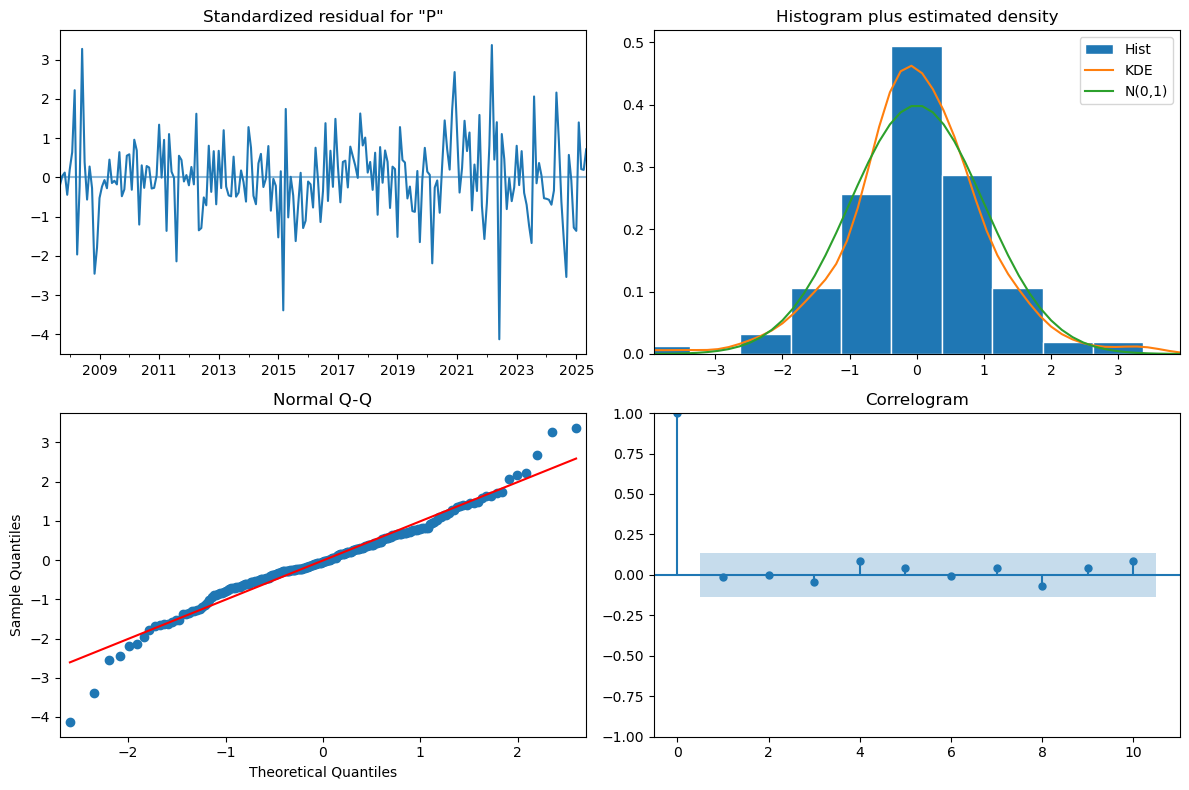

In [16]:
# Model Diagnostics
results.plot_diagnostics(figsize=(12, 8))
plt.tight_layout()
plt.savefig('sarima_diagnostics.png')
plt.show()

In [19]:
print(forecast_df.tail(10))

                 Date  Forecasted Price
2049-08-01 2049-08-01      79465.681221
2049-09-01 2049-09-01      79623.260668
2049-10-01 2049-10-01      82461.465089
2049-11-01 2049-11-01      81681.530706
2049-12-01 2049-12-01      80894.265348
2050-01-01 2050-01-01      83277.160751
2050-02-01 2050-02-01      84455.645553
2050-03-01 2050-03-01      89539.533578
2050-04-01 2050-04-01      89911.466274
2050-05-01 2050-05-01      88500.890229
